# Cannibalisation model for experimenting (CatBoost + SHAP)

### Problem statement
* 3 products within the same category: SKU A, SKU B, SKU C
    * SKU C is a _premium_ version of SKU A
    * During regular periods (off-promotions) the sales of the products are independent
    * The volume, defined as price x units within the category is steady (customer's budget)
    * During the promotions of SKU C, product SKU A gets cannibalised
    
* Step 1: Demonstrate the detection of the cannibalisation using the wrapper over Causal Impact
* Step 2: Forecast with CatBoost
    

In [2]:
'''
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/order/Machine Learning Part/Preparing the 3rd paper'
!cp '/content/drive/My Drive/order/Machine Learning Part/Preparing the 3rd paper/fcn_helpers.py' .
!cp '/content/drive/My Drive/order/Machine Learning Part/Preparing the 3rd paper/fcn_simulation.py' .
!pip install pandas catboost numpy matplotlib sklearn tensorflow xlsxwriter autogluon mxnet
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\nproject_path = '/content/drive/My Drive/order/Machine Learning Part/Preparing the 3rd paper'\n!cp '/content/drive/My Drive/order/Machine Learning Part/Preparing the 3rd paper/fcn_helpers.py' .\n!cp '/content/drive/My Drive/order/Machine Learning Part/Preparing the 3rd paper/fcn_simulation.py' .\n!pip install pandas catboost numpy matplotlib sklearn tensorflow xlsxwriter autogluon mxnet\n"

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
import promotional_helpers as promies

#plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

In [4]:
output_folder = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/fake_cannibalisation')

Generate the baseline sales model

### Victimise/cannibalise product A.
On promotion, SKU C at SKU A's price range increases the sales.
The idea here is that the total volume does not change as customer's budget is pretty steady. 
Therefore, increased sales in C effectively shifts the sales of SKU A downwards.

In [5]:
_num_samples = 365
df_train, df_eval, cannibalisation_test_set = fsim.get_artificial_time_series(_num_samples = _num_samples)

In [6]:
df_train.shape, df_eval.shape, cannibalisation_test_set.shape

((281, 37), (30, 37), (55, 37))

In [7]:
df_train.head(3)

,level_0,index,baseline_sales_sku_A,price_sku_A,shelf_sales_sku_A,shelves_sku_A,noise_sku_A,sku_id_sku_A,promos_sku_A,day_index_sku_A,...,shelves_sku_C,noise_sku_C,sku_id_sku_C,promos_sku_C,day_index_sku_C,sales_volume_sku_C,x1_sku_C,x2_sku_C,category_volume,promos_sku_C_type
0,0,0,76.360097,7.037868,0.0,0.0,6,sku_A,False,1.0,...,0.0,2,sku_C,False,1.0,407.799481,76,192,963.596007,None
1,1,1,82.244266,5.859728,0.0,0.0,14,sku_A,False,2.0,...,0.0,2,sku_C,False,2.0,614.613759,77,42,1143.877984,None
2,2,2,92.842068,5.917098,0.0,0.0,12,sku_A,False,3.0,...,0.0,4,sku_C,False,3.0,166.103591,91,6,734.965346,None


## Demonstrate the detection of the cannibalisation

Copying the code done for the real market data. The names are completely misleading, sku_A is the cannibal and sku_B is the victim.

In [8]:
min_diff_in_units_from_reg_to_promo = 5
# when analysing the SKUs
min_promo_days=3
min_regular_days=6
# This threshold is used to detect uplifters based on the difference in average sales
sales_threshold = 1/3
# min AVG sales to be considered
min_avg_sales = 10
# LOESS - weekly
period_in_days = 7
# If true, use the sales without the weekly pattern
do_decomposition = False
# This threshold is used to detect the reduction in sales that one uplifter causes
cannibalisation_threshold = 1/3
be_verbose = True

min_ratio_change = 0.25

do_exclude_promos_SKU_B = False

In [9]:
# Get the promotions and split them into slots
promo_cannibal = df_train['promos_sku_C']

idx_pre_intervention, idx_post_intervention = \
    fhelp.split_promos_into_sequences(promo_cannibal, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

idx_holiday_to_exclude = np.zeros(df_train.shape[0], dtype=bool) 

availability_cannibal = np.ones(df_train.shape[0], dtype=bool)
sales_cannibal = df_train['baseline_sales_sku_C']

availability_victim = np.ones(df_train.shape[0], dtype=bool)
sales_victim = df_train['baseline_sales_sku_A']
promo_victim = np.zeros(df_train.shape[0], dtype=bool) 

# Shambles but it makes sense
sku_id_A = 'SKU_C'
sku_id_B = 'SKU_A'

### Run Causal Impact

In [10]:
ci_analysis = promies.calculate_causal_impact(sku_id_A, promo_cannibal, availability_cannibal, sales_cannibal, \
    sku_id_B, promo_victim, availability_victim, sales_victim, \
    idx_pre_intervention, idx_post_intervention, \
    idx_holiday_to_exclude, \
    min_diff_in_units_from_reg_to_promo, \
    min_ratio_change = min_ratio_change,\
    do_exclude_promos_SKU_B = do_exclude_promos_SKU_B, \
    be_verbose=be_verbose)

Summary of the current scenario (slot 0)
Before SKU A going on promo, the SKUs overlap for 13 days (promos on sku_B excluded: False)
When SKU_A is on promo, the SKUs overlap for 6 days
During the overlapping days, SKU B is on promo for 0 days
Average sales of sku B before sku A on promo 90.38
Average sales of sku B during sku A on promo 68.57
Average sales of sku B after sku A on promo 89.15 over 8 days - True
Diff in units from regular to promotion -21.81
Diff in units from cannibalisation to regular 20.58
Ratio of change 0.24 (the lower the closer (0,1)) False 

Summary of the current scenario (slot 1)
Before SKU A going on promo, the SKUs overlap for 27 days (promos on sku_B excluded: False)
When SKU_A is on promo, the SKUs overlap for 5 days
During the overlapping days, SKU B is on promo for 0 days
Average sales of sku B before sku A on promo 97.14
Average sales of sku B during sku A on promo 111.26
Average sales of sku B after sku A on promo 97.95 over 8 days - False
Diff in units

In [11]:
df_ci_analysis = pd.DataFrame(ci_analysis)

df_ci_analysis['percentage_cannibalisation'] = \
  100*df_ci_analysis.sku_B_avg_sales_during_promo_sku_A/df_ci_analysis.sku_B_regular_avg_sales

# start in 1
df_ci_analysis.slot_number += 1

df_ci_analysis

,cannibal,victim,slot_number,idx_regular_days,idx_promo_days,total_overlapping_days_regular,regular_to_promo_gap,total_overlapping_days_promo,competing_promo_days,sku_B_regular_avg_sales,...,diff_in_units_from_reg_to_promo,diff_in_units_from_promo_to_pos_promo,ratio_change,avg_actual,avg_predicted,avg_abs_effect,cum_abs_effect,posterior_tail_prob,prob_causal_effect,percentage_cannibalisation
0,SKU_C,SKU_A,3,"[51, 62]","[63, 69]",12,0,7,0,95.183623,...,58.306562,-65.364178,0.612569,36.877060,95.179166,-58.302105,-408.114735,0.000000,100.0000,38.743073
1,SKU_C,SKU_A,4,"[70, 102]","[103, 108]",33,0,6,0,95.194244,...,25.383203,-26.617499,0.266646,69.811041,95.205099,-25.394058,-152.364347,0.000999,99.9001,73.335360
2,SKU_C,SKU_A,6,"[124, 198]","[199, 205]",75,0,7,0,96.894269,...,50.581494,-57.557285,0.522028,46.312775,96.948482,-50.635707,-354.449951,0.000000,100.0000,47.797229
3,SKU_C,SKU_A,7,"[206, 266]","[267, 273]",61,0,7,0,99.571054,...,42.285262,-31.783088,0.424674,57.285791,99.024134,-41.738342,-292.168397,0.000000,100.0000,57.532575


#### Some work on the LaTeX table

In [12]:
vars_for_latex_table = [#'cannibal', 'victim',
 'slot_number',
 'idx_regular_days',
 'sku_B_regular_avg_sales',
 'idx_promo_days',
 'sku_B_avg_sales_during_promo_sku_A',
 'avg_predicted',
 'percentage_cannibalisation',
 'prob_causal_effect',
 'avg_abs_effect',
 'cum_abs_effect']

df_latex = df_ci_analysis[vars_for_latex_table].copy()
df_latex.head(2)

,slot_number,idx_regular_days,sku_B_regular_avg_sales,idx_promo_days,sku_B_avg_sales_during_promo_sku_A,avg_predicted,percentage_cannibalisation,prob_causal_effect,avg_abs_effect,cum_abs_effect
0,3,"[51, 62]",95.183623,"[63, 69]",36.877060,95.179166,38.743073,100.0000,-58.302105,-408.114735
1,4,"[70, 102]",95.194244,"[103, 108]",69.811041,95.205099,73.335360,99.9001,-25.394058,-152.364347


In [13]:
d = {
'slot_number': 'promo number',
'percentage_cannibalisation': 'perc cannibalisation',
'sku_B_regular_avg_sales': '$\mu_{victim}$ regular days',
'sku_B_avg_sales_during_promo_sku_A': '$\mu_{victim}$ cannibalisation days',
'avg_predicted': '$\mu_{predicted}$',
'cum_abs_effect': '$\mu$ cum effect',
'avg_abs_effect': '$\mu$ daily losses',
'prob_causal_effect': '$P_{CE}$'
}

df_latex.rename(columns=d, inplace=True)

str_latex = df_latex.to_latex(index=False, float_format='{:3.2f}'.format)
#str_latex= str_latex.replace('\textbackslash ', '\\')
#str_latex= str_latex.replace('\_', ' ')
str_latex= str_latex.replace('\$', '$')
print(str_latex)

prefix = 'surrogate_model'
tex_file_name = os.path.join(output_folder, prefix + '_table.tex')
fhelp.writeTextFile(str_latex, tex_file_name)

\begin{tabular}{rlrlrrrrrr}
\toprule
 promo number & idx\_regular\_days &  $\textbackslash mu\_\{victim\}$ regular days & idx\_promo\_days &  $\textbackslash mu\_\{victim\}$ cannibalisation days &  $\textbackslash mu\_\{predicted\}$ &  perc cannibalisation &  $P\_\{CE\}$ &  $\textbackslash mu$ daily losses &  $\textbackslash mu$ cum effect \\
\midrule
            3 &         [51, 62] &                        95.18 &       [63, 69] &                                36.88 &              95.18 &                 38.74 &    100.00 &              -58.30 &           -408.11 \\
            4 &        [70, 102] &                        95.19 &     [103, 108] &                                69.81 &              95.21 &                 73.34 &     99.90 &              -25.39 &           -152.36 \\
            6 &       [124, 198] &                        96.89 &     [199, 205] &                                46.31 &              96.95 &                 47.80 &    100.00 &              -50.64 &  

### Produce the graph for the paper

In [18]:
f, ax = plt.subplots(1,1,figsize=(fig_w*1.5*1.5, fig_h))
plt.rcParams.update({'font.size': 30})

x_axis = df_train.index
x_axis_eval = df_eval.index + df_train.shape[0] - 1
x_axis_test = cannibalisation_test_set.index + df_train.shape[0] + df_eval.shape[0] - 2

idx_store = 0

idx_axis = 0
ax.plot(x_axis, sales_cannibal, label=f'Sales CN {sku_id_A}',
        color=def_colours[idx_store], linewidth=2, alpha=0.65)

ax.plot(x_axis, sales_victim, label=f'Sales VC {sku_id_B}',
        color=def_colours[idx_store+1], linewidth=2, alpha=0.65)



## Add the detected cannibalisation episodes

for _,irow in df_ci_analysis.iterrows():
    start_period = irow.idx_promo_days[0]
    end_period = irow.idx_promo_days[1]+1

    ax.plot(x_axis[start_period:end_period], sales_cannibal[start_period:end_period],
            color=def_colours[idx_store], linewidth=3, alpha=0.95)

    ax.plot(x_axis[start_period:end_period], sales_victim[start_period:end_period],
            color=def_colours[idx_store+1], linewidth=3, alpha=0.95)

    ax.axvspan(x_axis[start_period], x_axis[end_period], alpha=0.1, color='red')

    
promo_sku_A = promo_cannibal
ax.plot(x_axis[promo_sku_A], sales_cannibal[promo_sku_A], '.', label=f'Promo days {sku_id_A}', 
            color='g', linewidth=3.5, alpha=0.95)

'''
promo_sku_B = promo_victim
ax.plot(x_axis[promo_sku_B], sales_victim[promo_sku_B], '*', label=f'Promo days {sku_id_B}', 
            color=def_colours[-4], linewidth=2.5, alpha=0.95)
'''

# Add the promos that have not been identified as cannibals
start_end = [46,51,117,124]

for ix in start_end: 
    ax.axvline(x=ix, linewidth=0.5, color='grey', linestyle='dashed')

ax.axvspan(start_end[0], start_end[1], alpha=0.1, color='grey')
ax.axvspan(start_end[2], start_end[3], alpha=0.05, color='grey')
    
    
# add evaluation
idx_store = 0
ax.axvline(x=x_axis_eval[0], linewidth=1.5, color='grey', linestyle='dotted')
ax.plot(x_axis_eval, df_eval['baseline_sales_sku_C'], label=f'Eval CN {sku_id_A}',
        color=def_colours[idx_store], linewidth=4, alpha=1, linestyle='dotted')

ax.plot(x_axis_eval, df_eval['baseline_sales_sku_A'], label=f'Eval VC {sku_id_A}',
        color=def_colours[idx_store+1], linewidth=4, alpha=1, linestyle='dotted')

# add the test
ax.axvline(x=x_axis_test[0], linewidth=3.5, color='grey', linestyle='dashed')
ax.plot(x_axis_test, cannibalisation_test_set['baseline_sales_sku_C'], label=f'Test CN {sku_id_A}',
        color=def_colours[idx_store], linewidth=3.8, alpha=0.95, linestyle='dashed')

ax.plot(x_axis_test, cannibalisation_test_set['baseline_sales_sku_A'], label=f'Test VC {sku_id_A}',
        color=def_colours[idx_store+1], linewidth=3.8, alpha=0.95, linestyle='dashed')
    
    
    
plt.margins(0,0)
plt.legend()
plt.xlabel('Days')
plt.ylabel(f'Sales')
plt.grid(True)
plt.tight_layout()

save_to_file = True

if save_to_file:
    plt_filename = os.path.join(output_folder, f'{sku_id_A}-{sku_id_B}-all_slots_all_sets.pdf')
    plt.savefig(plt_filename)
    plt.close()
    print(f'File saved to {plt_filename}')

File saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/fake_cannibalisation/SKU_C-SKU_A-all_slots_all_sets.pdf


In [137]:
x_axis_test[0]+21

330

## CatBoost applied to cannibalisation

### Model

We assume that we are able to detect that SKU C cannibalises/haloes SKU A. We train the CatBoost model on the combined data of SKU A and SKU C. The reponse variable is the sales of SKU A. We then analyse both the feature importance and the accuracy.

### Variables and sets

In [138]:
# General hyperparameters
idx_categorical_features = None

num_iterations=250
learning_rate=0.05
depth=8
cat_features=idx_categorical_features
loss_function='RMSE'

In [139]:
model_type = 'CatBoost MTR'
## Model
'''
input_varnames = [ 'price_sku_A', 'promos_sku_A', 'week_number_sku_A', 'x1_sku_A', 'x2_sku_A',
 'price_sku_C', 'promos_sku_C', 'week_number_sku_C', 'x1_sku_C', 'x2_sku_C', 'promos_sku_C_type']
'''

# Cutting off promos in A (as always False) and promos in C, as it is collinear with promos_sku_C_type
input_varnames = [ 'price_sku_A', 'day_index_sku_A', 'x1_sku_A', 'x2_sku_A',
 'price_sku_C', 'day_index_sku_C', 'x1_sku_C', 'x2_sku_C', 'promos_sku_C_type']

interaction_responseVars = ['baseline_sales_sku_A']

X_train = df_train[input_varnames]
y_train = df_train[interaction_responseVars]
X_eval  = df_eval[input_varnames]
y_eval  = df_eval[interaction_responseVars]
eval_set = [(X_eval, y_eval)]

In [140]:
loss_function='RMSE'

# CatBoost
cb_model_A_C = CatBoostRegressor(iterations=num_iterations, learning_rate=learning_rate, \
                             depth=depth, loss_function=loss_function, \
                             cat_features=['promos_sku_C_type'], silent=False)


cb_model_A_C.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=50)

0:	learn: 25.5557743	test: 18.2688815	best: 18.2688815 (0)	total: 6.83ms	remaining: 1.7s
50:	learn: 15.4677725	test: 15.5667090	best: 15.5667090 (50)	total: 214ms	remaining: 835ms
100:	learn: 11.6046431	test: 15.3877895	best: 15.3303760 (81)	total: 435ms	remaining: 642ms
150:	learn: 9.3872291	test: 15.7141559	best: 15.3303760 (81)	total: 657ms	remaining: 431ms
200:	learn: 7.4020400	test: 15.7999696	best: 15.3303760 (81)	total: 904ms	remaining: 220ms
249:	learn: 5.9792652	test: 15.6552209	best: 15.3303760 (81)	total: 1.13s	remaining: 0us

bestTest = 15.33037599
bestIteration = 81

Shrink model to first 82 iterations.


In [141]:
df_features_A_C = pd.DataFrame(cb_model_A_C.get_feature_importance(), \
                               index = input_varnames, columns=['Importance'])
df_features_A_C.sort_values(by='Importance', inplace=True, ascending=False)
# Why the weight of price_sku_C	is pretty much the same as the noise variables? Is it because the promotional flag
# already encapsulates that info? If I were to calculate Y_C, would the price also be ignored?

### Overview of variable importance

In [142]:

'''df_feature_importance = pd.concat([df_features_A, df_features_MRT, df_features_A_C, \
                                   df_features_ABC.loc[input_varnames], df_contrastive], axis=1)'''

df_feature_importance = 100*df_features_A_C/df_features_A_C.sum()

str_latex = df_feature_importance.T.to_latex(index=True, float_format='{:3.2f}'.format,
                                           na_rep='', bold_rows=True,
                                          column_format='c')
prefix = 'var_importance'
tex_file_name = os.path.join(output_folder, prefix + '_table.tex')
fhelp.writeTextFile(str_latex, tex_file_name)
df_feature_importance

,Importance
promos_sku_C_type,30.246052
price_sku_A,30.195518
price_sku_C,9.591287
x1_sku_A,6.364697
x2_sku_C,5.644563
day_index_sku_C,5.177184
x2_sku_A,4.747032
x1_sku_C,4.639387
day_index_sku_A,3.394279


In [143]:
for _, iRow in df_feature_importance.iterrows():
    print(f'''{iRow.name.replace('_',' ')}={iRow.values[0]:3.2f}\\%''', end=',')

promos sku C type=30.25\%,price sku A=30.20\%,price sku C=9.59\%,x1 sku A=6.36\%,x2 sku C=5.64\%,day index sku C=5.18\%,x2 sku A=4.75\%,x1 sku C=4.64\%,day index sku A=3.39\%,

## Benchmark the models

In [144]:
# cannibalisation_test_set represents SKU C cannibalising SKU A
cannibalisation_test_set[10:30]['price_sku_C'].head(10)

10    11.057102
11    12.725054
12    12.190277
13     9.457304
14     7.272010
15     9.222170
16    10.995516
17     9.728139
18     8.599500
19    12.797310
Name: price_sku_C, dtype: float64

#### Prediction: The models are evaluated on overall accuracy, and on and off cannibalisation

In [145]:
# only interested in y_A
X_cannibalisation = cannibalisation_test_set[input_varnames]
y_cb_model_A_C = cb_model_A_C.predict(X_cannibalisation)


# Actual sales
y_actual = cannibalisation_test_set['baseline_sales_sku_A']


# Organise in a DF
df_test_products = pd.DataFrame()
df_test_products['y_hat_cb_model_A_C'] = y_cb_model_A_C

### Overall accuracy

In [146]:
df_frc_metrics = []
models_to_compare = ['cb_model_A_C']
for model_type in models_to_compare:
    df_frc_metrics.append(pd.DataFrame(\
       [fhelp.get_frc_errors(y_actual, \
        df_test_products['y_hat_' + model_type], False)], \
       index=[model_type]))

df_frc_metrics = pd.concat(df_frc_metrics)
df_frc_metrics


,MAE,MSE,RMSE,meanError,MAPE,R2,frc_error,frc_bias,frc_acc,Var explained,mu_y,mu_y_hat,sigma_y,sigma_y_hat
cb_model_A_C,16.84484,445.060257,21.096451,-3.134661,inf,0.5517,0.197989,-0.035535,1.035535,0.561598,85.079715,88.214376,31.798725,15.675916


In [147]:
# overall_accuracy to tex
vars_to_keep = ['MAE', 'MSE', 'RMSE', 'meanError', 'R2', 'frc_error', 'frc_bias', 'frc_acc']
tex_file_name = fhelp.fullfile('tex', 'accurac_summary_table.tex')
str_latex = df_frc_metrics[vars_to_keep].to_latex(index=True, float_format='{:3.2f}'.format,
                                           na_rep='', bold_rows=True,
                                          column_format='c', caption='caption here', label='label here')
#str_latex = latex_prefix + str_latex + latex_postfix
#fhelp.writeTextFile(str_latex, tex_file_name)
str_old = 'egin{tabular}{c}'
str_new = 'egin{tabular}{'+ 'c|'*(len(vars_to_keep)+1) + '}'
print(str_latex.replace(str_old, str_new))

\begin{table}
\centering
\caption{caption here}
\label{label here}
\begin{tabular}{c|c|c|c|c|c|c|c|c|}
\toprule
{} &   MAE &    MSE &  RMSE &  meanError &   R2 &  frc\_error &  frc\_bias &  frc\_acc \\
\midrule
\textbf{cb\_model\_A\_C} & 16.84 & 445.06 & 21.10 &      -3.13 & 0.55 &       0.20 &     -0.04 &     1.04 \\
\bottomrule
\end{tabular}
\end{table}



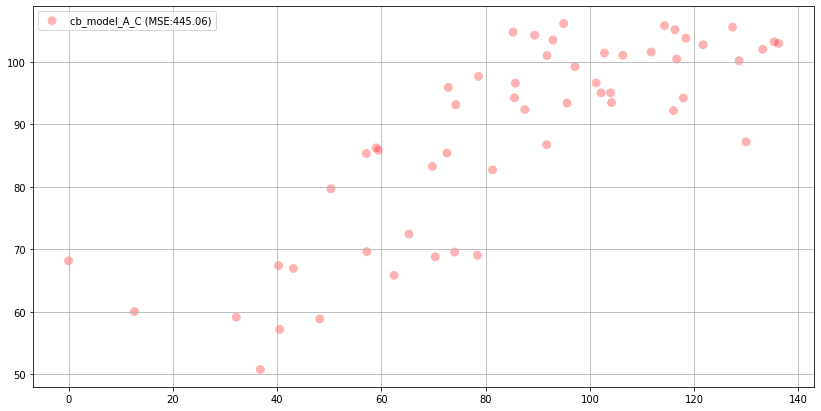

In [148]:
fig, ax = plt.subplots()
colours = ['red', 'green', 'orange', 'blue', 'magenta']
for idx_model, model_type in enumerate(models_to_compare):
    y_hat = df_test_products['y_hat_' + model_type].values
    mse = df_frc_metrics.loc[model_type, 'MSE']
    label_txt = model_type + f' (MSE:{mse:3.2f})'
    ax.scatter(y_actual, y_hat, 
               label=label_txt, 
               c=colours[idx_model],
              alpha=0.3, edgecolors='none',
              s=80)
ax.legend()
ax.grid(True)

plt.show()

### Accuracy during cannibalisation

In [149]:
idx_promo_SKU_C = cannibalisation_test_set['promos_sku_C']
df_frc_metrics = []
for model_type in models_to_compare:
    df_frc_metrics.append(pd.DataFrame(\
       [fhelp.get_frc_errors(y_actual[idx_promo_SKU_C], \
        df_test_products['y_hat_' + model_type][idx_promo_SKU_C], False)], \
       index=[model_type]))

df_frc_metrics_cannibalisation = pd.concat(df_frc_metrics)
df_frc_metrics_cannibalisation

,MAE,MSE,RMSE,meanError,MAPE,R2,frc_error,frc_bias,frc_acc,Var explained,mu_y,mu_y_hat,sigma_y,sigma_y_hat
cb_model_A_C,20.652241,730.66421,27.030801,-14.176863,inf,0.056774,0.375699,-0.205025,1.205025,0.316227,54.970207,69.147069,28.639325,10.453436


In [150]:
# Accuracy during cannibalisation
vars_to_keep = ['MAE', 'MSE', 'RMSE', 'meanError', 'R2', 'frc_error', 'frc_bias', 'frc_acc']
str_latex = df_frc_metrics_cannibalisation[vars_to_keep].to_latex(index=True, float_format='{:3.2f}'.format,
                                           na_rep='', bold_rows=True,
                                          column_format='c', caption='caption here', label='label here')
str_old = 'egin{tabular}{c}'
str_new = 'egin{tabular}{'+ 'c|'*(len(vars_to_keep)+1) + '}'
print(str_latex.replace(str_old, str_new))

\begin{table}
\centering
\caption{caption here}
\label{label here}
\begin{tabular}{c|c|c|c|c|c|c|c|c|}
\toprule
{} &   MAE &    MSE &  RMSE &  meanError &   R2 &  frc\_error &  frc\_bias &  frc\_acc \\
\midrule
\textbf{cb\_model\_A\_C} & 20.65 & 730.66 & 27.03 &     -14.18 & 0.06 &       0.38 &     -0.21 &     1.21 \\
\bottomrule
\end{tabular}
\end{table}



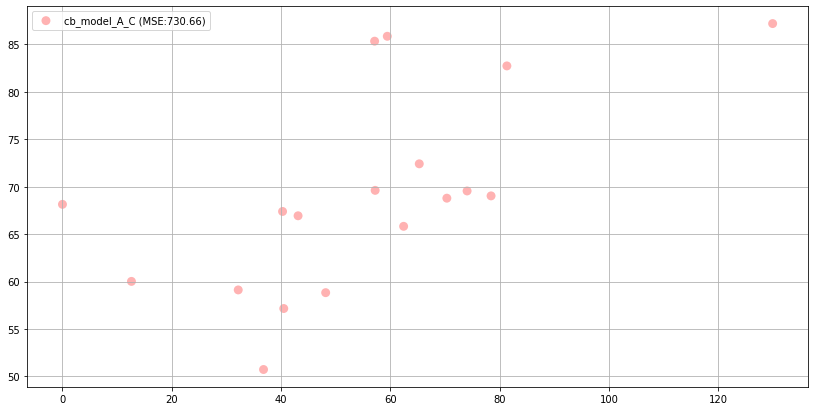

In [151]:
fig, ax = plt.subplots()
colours = ['red', 'green', 'orange', 'blue', 'magenta']
for idx_model, model_type in enumerate(models_to_compare):
    y_hat = df_test_products['y_hat_' + model_type].values
    mse = df_frc_metrics_cannibalisation.loc[model_type, 'MSE']
    label_txt = model_type + f' (MSE:{mse:3.2f})'
    ax.scatter(y_actual[idx_promo_SKU_C], y_hat[idx_promo_SKU_C], 
               label=label_txt, 
               c=colours[idx_model],
              alpha=0.3, edgecolors='none',
              s=80)
ax.legend()
ax.grid(True)

plt.show()

### Accuracy during regular/equilibrium periods (non-cannibalisation)

In [152]:
df_frc_metrics = []
for model_type in models_to_compare:
    df_frc_metrics.append(pd.DataFrame(\
       [fhelp.get_frc_errors(y_actual[~idx_promo_SKU_C], \
        df_test_products['y_hat_' + model_type][~idx_promo_SKU_C], False)], \
       index=[model_type]))

df_frc_metrics_off_cannibalisation = pd.concat(df_frc_metrics)
df_frc_metrics_off_cannibalisation

,MAE,MSE,RMSE,meanError,MAPE,R2,frc_error,frc_bias,frc_acc,Var explained,mu_y,mu_y_hat,sigma_y,sigma_y_hat
cb_model_A_C,14.992591,306.117794,17.496222,2.23722,15.938282,0.309444,0.150335,0.022948,0.977052,0.320735,99.727583,97.490363,21.344911,6.839929


In [153]:
# Accuracy during equilibrium periods (NO-cannibalisation)
vars_to_keep = ['MAE', 'MSE', 'RMSE', 'meanError', 'R2', 'frc_error', 'frc_bias', 'frc_acc']
str_latex = df_frc_metrics_off_cannibalisation[vars_to_keep].to_latex(index=True, float_format='{:3.2f}'.format,
                                           na_rep='', bold_rows=True,
                                          column_format='c', caption='caption here', label='label here')
str_old = 'egin{tabular}{c}'
str_new = 'egin{tabular}{'+ 'c|'*(len(vars_to_keep)+1) + '}'
print(str_latex.replace(str_old, str_new))

\begin{table}
\centering
\caption{caption here}
\label{label here}
\begin{tabular}{c|c|c|c|c|c|c|c|c|}
\toprule
{} &   MAE &    MSE &  RMSE &  meanError &   R2 &  frc\_error &  frc\_bias &  frc\_acc \\
\midrule
\textbf{cb\_model\_A\_C} & 14.99 & 306.12 & 17.50 &       2.24 & 0.31 &       0.15 &      0.02 &     0.98 \\
\bottomrule
\end{tabular}
\end{table}



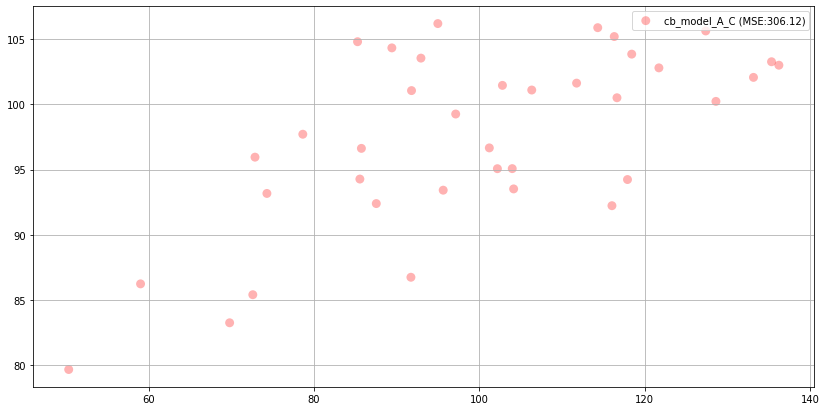

In [154]:
fig, ax = plt.subplots()
colours = ['red', 'green', 'orange', 'blue']
model_list = ['cb_model_A_C']
for idx_model, model_type in enumerate(model_list):
    y_hat = df_test_products['y_hat_' + model_type].values
    mse = df_frc_metrics_off_cannibalisation.loc[model_type, 'MSE']
    label_txt = model_type + f' (MSE:{mse:3.2f})'
    ax.scatter(y_actual[~idx_promo_SKU_C], y_hat[~idx_promo_SKU_C], 
               label=label_txt, 
               c=colours[idx_model],
              alpha=0.3, edgecolors='none',
              s=80)
ax.legend()
ax.grid(True)

plt.show()

How to use LaTeX in here
<table>
    <tr>
        <td>
\begin{eqnarray}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}\vec{\mathbf{j}} \\
\nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\end{eqnarray}
        </td>
        <td>
\begin{eqnarray}
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0
\end{eqnarray}
        </td>
    </tr>
</table>

### SHAP to the rescue
SKU A gets cannibalised by SKU C. 
Let's see how SHAP shows that. We expect a high dependancy on the promotional flag of SKU C.

In [155]:
import shap
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(cb_model_A_C)
shap_values = explainer.shap_values(X_cannibalisation)

### Cannibalisation plot

In [156]:
# Round decimals for the SHAP plot
numericalVars = cannibalisation_test_set[input_varnames].select_dtypes(include=['number']).columns.tolist()
cut_off_decimals = lambda x_in: np.around(x_in, decimals=2)
cannibalisation_test_set[numericalVars] = cannibalisation_test_set[numericalVars].applymap(cut_off_decimals)

X_cannibalisation = cannibalisation_test_set[input_varnames].values

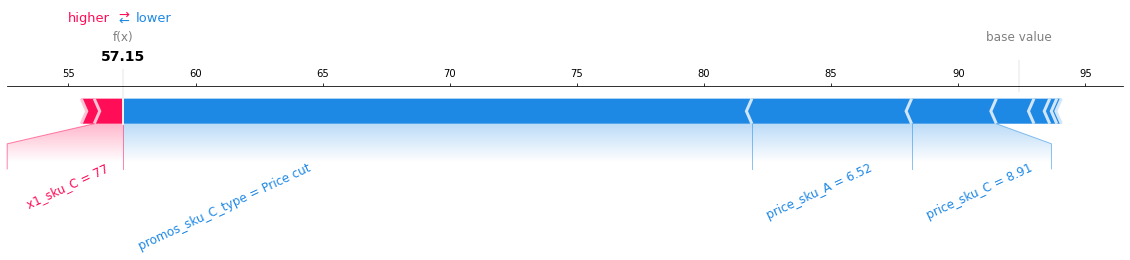

In [164]:
plot_name = 'cannibalisation'
idx = 20
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_cannibalisation[idx,:], 
               feature_names=input_varnames, text_rotation=25,show=False,matplotlib=True)#.savefig()

plt_folder = os.path.join(output_folder,'shap_plots')
fhelp.makeFolder(plt_folder)
plt_filename = os.path.join(plt_folder, plot_name + '_idx_'+ str(idx) + '_.pdf')
plt.savefig(plt_filename, format='pdf', dpi=300, bbox_inches='tight')

### Non cannibalisation plot

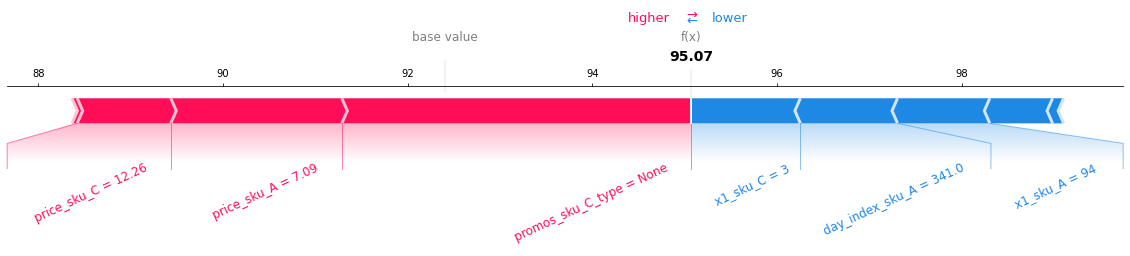

In [165]:
idx = 30
plot_name = 'non_cannibalisation'
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_cannibalisation[idx,:], 
               feature_names=input_varnames, text_rotation=25,show=False,matplotlib=True)#.savefig()

plt_filename = os.path.join(output_folder,'shap_plots', plot_name + '_idx_'+ str(idx) + '_.pdf')
plt.savefig(plt_filename, format='pdf', dpi=300, bbox_inches='tight')

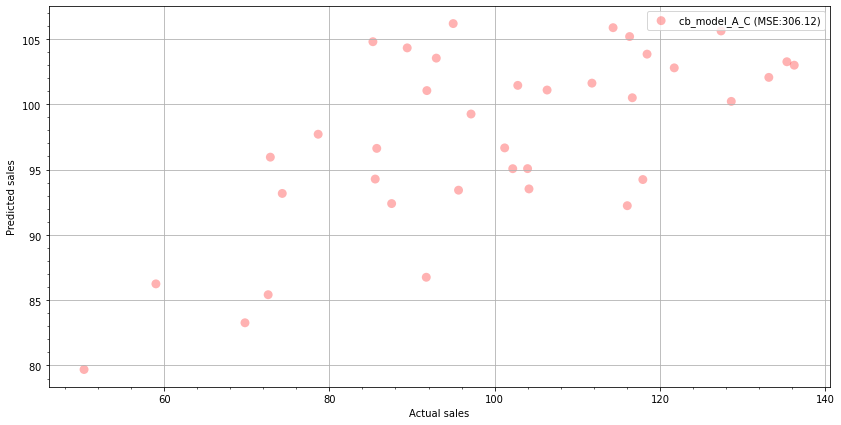

In [159]:
# Modify a chart for camera-ready print
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
fig, ax = plt.subplots()
colours = ['red', 'green', 'orange', 'blue']
model_list = ['cb_model_A_C']
for idx_model, model_type in enumerate(model_list):
    y_hat = df_test_products['y_hat_' + model_type].values
    mse = df_frc_metrics_off_cannibalisation.loc[model_type, 'MSE']
    label_txt = model_type + f' (MSE:{mse:3.2f})'
    ax.scatter(y_actual[~idx_promo_SKU_C], y_hat[~idx_promo_SKU_C], 
               label=label_txt, 
               c=colours[idx_model],
              alpha=0.3, edgecolors='none',
              s=80)
ax.legend()
ax.grid(True)
ax.set_xlabel('Actual sales')
ax.set_ylabel('Predicted sales')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.tick_left()
#ax.legend(frameon=False, loc='upper left',ncol=2,handlelength=4)
#plt.savefig(os.path.join(dirFile,'ProdCountries.pdf'),dpi=300)
plt.show()

In [160]:
# cannibalisation_test_set represents SKU C cannibalising SKU A
cannibalisation_test_set.loc[idx, input_varnames+[interaction_responseVars_A]]

NameError: name 'interaction_responseVars_A' is not defined

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, cannibalisation_test_set[input_varnames])

In [ ]:
shap.summary_plot(shap_values, cannibalisation_test_set[input_varnames], plot_type="bar")

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('price_sku_C', shap_values, cannibalisation_test_set[input_varnames])

### Leverage the contrastive Regressor
Look for cannibalisation relating the neighbours

In [ ]:
dm_frc = contrastiveReg.get_results()
dm_frc
#idx_closest_promos = [6,3,2]
idx_closest_promos = dm_frc['y_idx_closest_promos'][idx]
df_train.iloc[idx_closest_promos][input_varnames]
#df_train.iloc[idx_closest_promos, input_varnames]


In [ ]:
'''
  def arrange_regressor_results(self, idx_review, df_A_enc, y_train, id_train, inputVars_plain, \
    identifierVar, df_test_enc, y_test, num_inputVars):
'''
id_train = None
identifierVar = None
df_forecast_ext = contrastiveReg.arrange_regressor_results(idx, df_train, y_train_A,\
id_train, input_varnames, identifierVar, \
cannibalisation_test_set[input_varnames], y_actual, num_inputVars)

In [ ]:
df_forecast_ext

In [ ]:
cannibalisation_test_set.shape